In [380]:
import torch
from torch import nn
from torch.autograd import grad
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [381]:
############################################################
# CONSTANTS ################################################
############################################################

# number of samples
n_x_boundary = 100
n_x_interior = 100
# model structure
in_dim = 1
out_dim = 1
hidden_width = 100


############################################################
# DEFINE ANALYTICAL EQUATIONS ##############################
############################################################

def f_fn(x, a):
  return -(torch.pi*a)**2*torch.sin(a*torch.pi*x)

def g_fn(x, a):
  return torch.sin(a*torch.pi*x)

def u_fn(x, a):
  return torch.sin(a*torch.pi*x)



In [382]:
############################################################
# DEFINE MODEL #############################################
############################################################

class PINN_1D(nn.Module):
  def __init__(self,in_dim, out_dim, hidden_width, weight_std, bias_std):
    super(PINN_1D,self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hidden_width = hidden_width
    self.weight_std = weight_std
    self.bias_std = bias_std

    self.PINN=nn.Sequential(
        nn.Linear(self.in_dim, self.hidden_width),
        nn.Tanh(),
        nn.Linear(self.hidden_width, self.out_dim)
    )

    self.init_PINN()
  
  # Initialize model parameters
  def init_PINN(self):

    layer1 = self.PINN[0]
    layer2 = self.PINN[2]
  

    std_l1 = 1./np.sqrt(layer1.weight.shape[0])
    weight_random_l1 = torch.normal(0,1,size=layer1.weight.shape,dtype = torch.float32) * std_l1 * self.weight_std
    bias_random_l1 = torch.normal(0,1,size=layer1.bias.shape,dtype = torch.float32)  * self.bias_std
    layer1.weight = nn.Parameter(weight_random_l1)
    layer1.bias = nn.Parameter(bias_random_l1)


    std_l2 = 1./np.sqrt(layer2.weight.shape[0])
    weight_random_l2 = torch.normal(0,1,size=layer2.weight.shape,dtype = torch.float32)  * std_l2 * self.weight_std 
    bias_random_l2 = torch.normal(0,1,size=layer2.bias.shape,dtype = torch.float32)  * self.bias_std
    layer2.weight = nn.Parameter(weight_random_l2)
    layer2.bias = nn.Parameter(bias_random_l2)

    

  def forward(self, x):
    return self.PINN(x)

In [383]:
############################################################
# JAC. FUNCTION ############################################
############################################################

def calculate_jacobian(x_boundary, x_interior, model):

  model.train()

  mu_x, sigma_x = x_interior.mean(0), x_interior.std(0)
  # print(sigma_x)
  J_u = []
  for x in x_boundary:
    x.requires_grad_()
    model.zero_grad()
    model(x).backward()
    grads = []
    for param in model.parameters():
      grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    J_u.append(grads)
  J_u = torch.stack(J_u,0)


  J_f = []
  for x in x_interior:
    x.requires_grad_()
    model.zero_grad()
    u_pred = model(x)
    
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] / sigma_x
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),create_graph=True)[0] / sigma_x

    u_xx.backward(retain_graph=True)
    
    grads = []
    for param in model.parameters():
      if param.grad==None:
        grads.append(torch.zeros_like(torch.Tensor(param.data.shape).view(-1)).to(x.device))
      else:
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    J_f.append(grads)
  J_f = torch.stack(J_f,0)

  J_uf = torch.cat((J_u,J_f),0)

  return J_u, J_f, J_uf

############################################################
# NTKS FUNCTION ############################################
############################################################

def compute_ntks(J_u, J_f, J_uf):
  K_uu = torch.matmul(J_u,J_u.T)
  K_ff = torch.matmul(J_f,J_f.T)
  K_uf = torch.matmul(J_uf,J_uf.T)

  L_uu = torch.linalg.eigvals(K_uu)
  L_ff = torch.linalg.eigvals(K_ff)
  L_uf = torch.linalg.eigvals(K_uf)

  L_uu_real = torch.real(L_uu)
  L_uu_real, indeces = torch.sort(L_uu_real,descending=True)
  L_uu_real = L_uu_real.cpu()

  L_ff_real = torch.real(L_ff)
  L_ff_real, indeces = torch.sort(L_ff_real,descending=True)
  L_ff_real = L_ff_real.cpu()

  L_uf_real = torch.real(L_uf)
  L_uf_real, indeces = torch.sort(L_uf_real,descending=True)
  L_uf_real = L_uf_real.cpu()
  return L_uf_real, L_uu_real, L_ff_real, K_uf

In [384]:
############################################################
# TRAIN FUNCTION ###########################################
############################################################

def train(x_boundary, x_interior, g_boundary, f_interior, model, loss_fn, optimizer):

  model.train()

  # Normalize
  mu_x, sigma_x = x_interior.mean(0), x_interior.std(0)

  x_interior = (x_interior-mu_x)/sigma_x 
  x_boundary = (x_boundary-mu_x)/sigma_x 
  x_interior.requires_grad_()
  x_boundary.requires_grad_()
  

  # boundary prediction
  u_boundary_pred = model(x_boundary)
  g_pred = u_boundary_pred
  g_true = g_boundary
  
  # interior prediction
  u_interior_pred = model(x_interior)
  u_x = grad(u_interior_pred, x_interior, grad_outputs=torch.ones_like(u_interior_pred),create_graph=True)[0]
  u_xx = grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x),create_graph=True)[0]
  f_pred = u_xx
  f_true = f_interior
  

  # loss
  L_b = loss_fn(g_pred, g_true)
  L_r = loss_fn(f_pred, f_true)
  L = L_b + L_r
  

  # backpropagation
  optimizer.zero_grad()
  L.backward()
  optimizer.step()

  # record parameters
  params = []
  for param in model.parameters():
    params.append(param.data.view(-1))
  params = torch.cat(params)

  # record ntk and eigenvalues
  J_u, J_f, J_uf = calculate_jacobian(x_boundary, x_interior, model)
  L_uf_real, L_uu_real, L_ff_real, K = compute_ntks(J_u, J_f, J_uf)
  
  eign = L_uf_real

  loss = L.item()
  return loss, params, K, eign


############################################################
# TEST FUNCTION ############################################
############################################################

def test(a, x_boundary, x_interior, g_boundary, f_interior, model, loss_fn):
  # Normalize
  mu_x, sigma_x = x_interior.mean(0), x_interior.std(0)

  x_interior = (x_interior-mu_x)/sigma_x 
  x_boundary = (x_boundary-mu_x)/sigma_x 
  
  model.eval()
  with torch.no_grad():
    u_boundary_pred = model(x_boundary)
    u_interior_pred = model(x_interior)
  
  u_boundary_true = u_fn(a, x_boundary)
  u_interior_true = u_fn(a, x_interior)
  # g_true = g_boundary

  loss_boudary = loss_fn(u_boundary_pred, u_boundary_true)
  loss_interior = loss_fn(u_interior_pred, u_interior_true)
  print(f"loss_boundary: {loss_boudary} loss_interior: {loss_interior}")


In [385]:
############################################################
# GENERATE DATASET ############################################
############################################################
def create_pde(n_x_boundary, n_x_interior, u_fn, f_fn, g_fn, a, device):
  x_boundary_left = torch.zeros(n_x_boundary // 2,1)
  x_boundary_right = torch.ones(n_x_boundary // 2,1)
  x_boundary = torch.vstack([x_boundary_left,x_boundary_right]).to(device)

  x_interior = torch.linspace(0,1, n_x_interior).to(device)
  x_interior = torch.unsqueeze(x_interior, dim=1)

  u_boundary = u_fn(x_boundary, a).to(device)
  u_interior = u_fn(x_interior, a).to(device)
  
  g_boundary = g_fn(x_boundary, a).to(device)
  f_interior = f_fn(x_interior, a).to(device)
  return x_boundary, x_interior, g_boundary, f_interior, 

# Figure 1#

In [386]:
# Compute eigenvalues of ntk at initialization
L_init = []
weight_std = .7*1e1
bias_std = 1
for a in [1,2,4]:
  model = PINN_1D(in_dim, out_dim, hidden_width, weight_std, bias_std).to(device)

  print(a)
  x_boundary, x_interior, g_boundary, f_interior = create_pde(n_x_boundary, n_x_interior, u_fn, f_fn, g_fn, a, device)
  
  # Normalize
  mu_x, sigma_x = x_interior.mean(0), x_interior.std(0)
  x_interior = (x_interior-mu_x)/sigma_x 
  x_boundary = (x_boundary-mu_x)/sigma_x 

  
  J_u, J_f, J_uf = calculate_jacobian(x_boundary, x_interior, model)
  L_uf_init, L_uu_init, L_ff_init, K = compute_ntks(J_u, J_f, J_uf)
  L_init.append([L_uf_init, L_uu_init, L_ff_init])


1
2
4


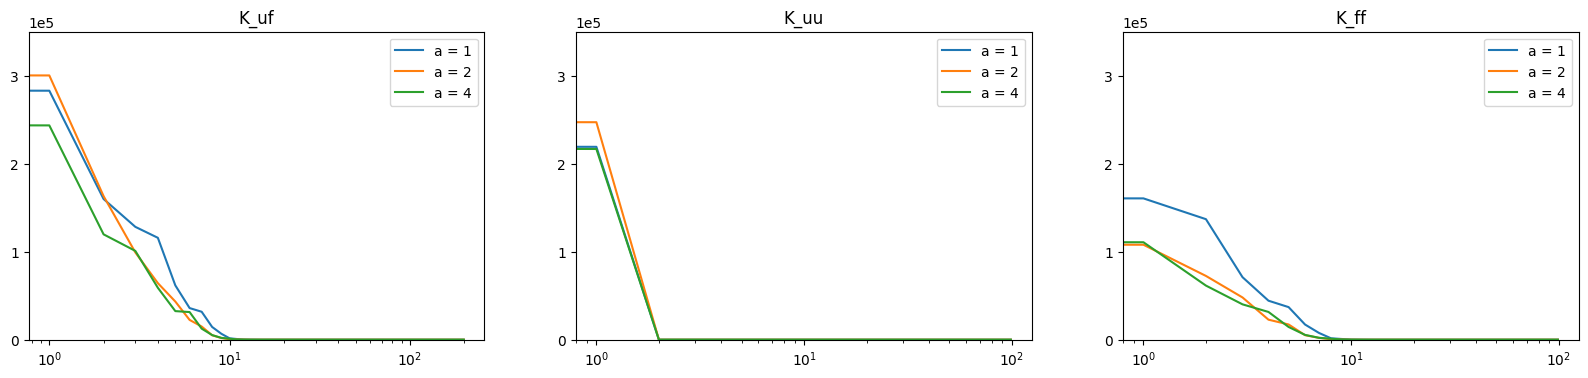

In [387]:
# plot figure 1
fig, ax = plt.subplots(1, 3,figsize=(20, 4))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')


# fig.suptitle('Horizontally stacked subplots')
ax[0].plot(L_init[0][0], label = 'a = 1')
ax[1].plot(L_init[0][1], label = 'a = 1')
ax[2].plot(L_init[0][2], label = 'a = 1')

ax[0].plot(L_init[1][0], label = 'a = 2')
ax[1].plot(L_init[1][1], label = 'a = 2')
ax[2].plot(L_init[1][2], label = 'a = 2')

ax[0].plot(L_init[2][0], label = 'a = 4')
ax[1].plot(L_init[2][1], label = 'a = 4')
ax[2].plot(L_init[2][2], label = 'a = 4')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title('K_uf')
ax[1].set_title('K_uu')
ax[2].set_title('K_ff')

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[0].set_ylim(0, 3.5e5)  # 3.5e3
ax[1].set_ylim(0, 3.5e5)
ax[2].set_ylim(0, 3.5e5)  # 3.5e5

ax[0].set_yticks([0, 1e5, 2e5, 3e5])
ax[1].set_yticks([0, 1e5, 2e5, 3e5])
ax[2].set_yticks([0, 1e5, 2e5, 3e5])

plt.show()


# Figure 2#

In [388]:
# Record relative changes of NTKs and parameters of networks with different hidden widths
param_diff_all = []
ntk_diff_all = []
eign_all = []

weight_std = 0.5*1e1 
bias_std = 0.03*1e1 


# Train models with different hidden width
for hidden_width in [10, 100, 500]:

  # Create model
  model = PINN_1D(in_dim, out_dim, hidden_width, weight_std, bias_std).to(device)

  # Define loss and optimizer
  loss_fn = nn.MSELoss(reduction='mean')
  optimizer = torch.optim.SGD(model.parameters(),lr=1e-5)
  scheduler = ExponentialLR(optimizer, gamma = 0.9)

  a = 1
  x_boundary, x_interior, g_boundary, f_interior = create_pde(n_x_boundary, n_x_interior, u_fn, f_fn, g_fn, a, device)
  
  params = []
  ntks = []
  eigns = []

  epoch = 10000
  for iter in range(epoch):
    loss, param, ntk, eign = train(x_boundary, x_interior, g_boundary, f_interior, model, loss_fn, optimizer)
    param = param.cpu()
    ntk = ntk.cpu()

    params.append(param)
    ntks.append(ntk)
    eigns.append(eign)

    if iter % 200 == 0:
      print(f"loss: {loss:>3f}      || iter: {iter:>5d}")

    if iter % 1000 == 0:
      scheduler.step()
  print("Done!")

  test(a, x_boundary, x_interior, g_boundary, f_interior, model, loss_fn)
  # data at initialization
  param_0 = params[0]
  ntk_0 = ntks[0]
  eign_0 = eigns[0]

  # data differences
  param_diffs = []
  ntk_diffs = []
  for i in range(len(params)):
    param_diff = np.linalg.norm(params[i] - param_0, ord=2)/np.linalg.norm(param_0, ord=2)
    ntk_diff = np.linalg.norm(ntks[i] - ntk_0, ord=2)/np.linalg.norm(ntk_0, ord=2)

    param_diffs.append(param_diff)
    ntk_diffs.append(ntk_diff)

  param_diff_all.append(param_diffs)
  ntk_diff_all.append(ntk_diffs)
  eign_all.append(eigns)


loss: 623.019287      || iter:     0
loss: 159.250793      || iter:   200
loss: 113.757240      || iter:   400
loss: 88.762665      || iter:   600
loss: 73.665527      || iter:   800
loss: 64.184654      || iter:  1000
loss: 58.541245      || iter:  1200
loss: 54.628872      || iter:  1400
loss: 51.851051      || iter:  1600
loss: 49.833065      || iter:  1800
loss: 48.332928      || iter:  2000
loss: 47.292580      || iter:  2200
loss: 46.464378      || iter:  2400
loss: 45.792107      || iter:  2600
loss: 45.236652      || iter:  2800
loss: 44.769302      || iter:  3000
loss: 44.406845      || iter:  3200
loss: 44.087944      || iter:  3400
loss: 43.803814      || iter:  3600
loss: 43.547714      || iter:  3800
loss: 43.314537      || iter:  4000
loss: 43.120777      || iter:  4200
loss: 42.939919      || iter:  4400
loss: 42.769985      || iter:  4600
loss: 42.609413      || iter:  4800
loss: 42.456928      || iter:  5000
loss: 42.325577      || iter:  5200
loss: 42.199234      || i

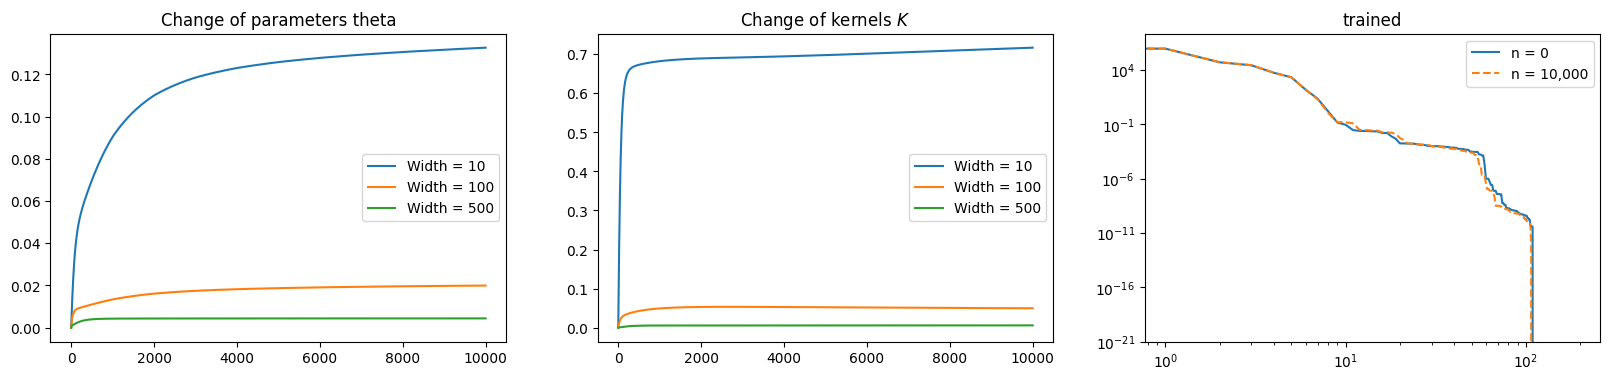

In [390]:
# plot figure 2
fig, ax = plt.subplots(1, 3,figsize=(20, 4))
ax[2].set_xscale('log')

ax[0].plot(param_diff_all[0], label = 'Width = 10')
ax[0].plot(param_diff_all[1], label = 'Width = 100')
ax[0].plot(param_diff_all[2], label = 'Width = 500')
ax[1].plot(ntk_diff_all[0], label = 'Width = 10')
ax[1].plot(ntk_diff_all[1], label = 'Width = 100')
ax[1].plot(ntk_diff_all[2], label = 'Width = 500')
ax[2].plot(eign_all[-1][0], label = 'n = 0')
ax[2].plot(eign_all[-1][-1], label = 'n = 10,000', linestyle = '--')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title('Change of parameters theta')
ax[1].set_title('Change of kernels $K$')
ax[2].set_title('trained')

ax[0].ticklabel_format(axis='y')
ax[1].ticklabel_format(axis='y')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[2].set_yscale('log')
ax[2].set_yticks([1e-21, 1e-16, 1e-11, 1e-6, 1e-1, 1e4])
plt.show()